# CNN Training

In this notebook we train a custom cnn model to classify the acquired images (bboxes) to the respective gesture.

We use the following annotated dataset:
Laurence Moroney — Rock, Paper, Scissors Dataset (Feb 2019). URL: http://laurencemoroney.com/rock-paper-scissors-dataset



## Get dataset

In [1]:
# Optional: install packages if missing (skip if already installed)
!pip install -U tensorflow tensorflow-datasets

import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow.keras import datasets, layers, models, optimizers
import matplotlib.pyplot as plt

In [2]:
# Load dataset with splits
(train_ds, val_ds, test_ds), ds_info = tfds.load(
    'rock_paper_scissors',
    split=['train[:80%]', 'train[80%:]', 'test'],
    with_info=True,
    as_supervised=True
)
num_classes = ds_info.features['label'].num_classes
class_names = ds_info.features['label'].names
print('Train:', ds_info.splits['train'].num_examples * 0.8)
print('Val:', ds_info.splits['train'].num_examples * 0.2)
print('Test:', ds_info.splits['test'].num_examples)

Train: 2016.0
Val: 504.0
Test: 372


In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(label, depth=num_classes)
    return image, label

def augment(image, label):
    image = data_augmentation(image)
    return image, label

def mixup(batch_x, batch_y, alpha=0.2):
    # batch_x: [B,H,W,C], batch_y: [B,num_classes]
    batch_size = tf.shape(batch_x)[0]
    # sample lam in [0,1]
    lam = tf.clip_by_value(tf.random.gamma(shape=[batch_size], alpha=alpha), 0.0, 1.0)  # [B]
    lam_x = tf.reshape(lam, [batch_size, 1, 1, 1])  # broadcast for images
    lam_y = tf.reshape(lam, [batch_size, 1])        # broadcast for labels

    idx = tf.random.shuffle(tf.range(batch_size))
    x2 = tf.gather(batch_x, idx)
    y2 = tf.gather(batch_y, idx)

    x = batch_x * lam_x + x2 * (1.0 - lam_x)
    y = batch_y * lam_y + y2 * (1.0 - lam_y)
    return x, y

train_ds_prep = (train_ds
                 .shuffle(2000)
                 .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
                 .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
                 .batch(BATCH_SIZE)
                 .map(mixup, num_parallel_calls=tf.data.AUTOTUNE)
                 .prefetch(tf.data.AUTOTUNE))

val_ds_prep = (val_ds
               .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
               .batch(BATCH_SIZE)
               .prefetch(tf.data.AUTOTUNE))

test_ds_prep = (test_ds
                .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
                .batch(BATCH_SIZE)
                .prefetch(tf.data.AUTOTUNE))

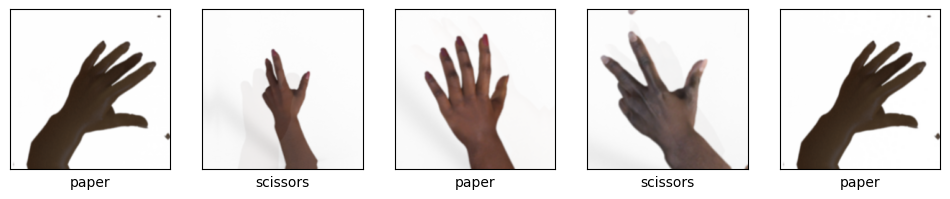

In [4]:
# Display 5 samples from the preprocessed training dataset (handles one-hot labels)
plt.figure(figsize=(12,3))
batch_images, batch_labels = next(iter(train_ds_prep))  # images: (B,224,224,3), labels: (B,3) or (B,)
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = tf.clip_by_value(batch_images[i], 0.0, 1.0) 
    label = batch_labels[i]
    # support both one-hot and integer labels
    try:
        class_id = int(tf.argmax(label).numpy())
    except Exception:
        class_id = int(label.numpy())
    plt.imshow(img)
    plt.xlabel(class_names[class_id])
plt.show()

In [5]:
# // ...existing code...
# Smaller model + stronger regularization
l2 = tf.keras.regularizers.l2(3e-4)
model = models.Sequential([
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.Conv2D(24, 3, activation='relu', padding='same', kernel_regularizer=l2),
    layers.Conv2D(24, 3, activation='relu', padding='same', kernel_regularizer=l2),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),

    layers.Conv2D(48, 3, activation='relu', padding='same', kernel_regularizer=l2),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),

    layers.Conv2D(72, 3, activation='relu', padding='same', kernel_regularizer=l2),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),

    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(96, activation='relu', kernel_regularizer=l2),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(num_classes, activation='softmax')
])


In [6]:
# Lower LR, enable callbacks
try:
    optimizer = tf.keras.optimizers.experimental.AdamW(learning_rate=1e-4, weight_decay=1e-4)
except Exception:
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['categorical_accuracy']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=8, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-5)
]

history = model.fit(
    train_ds_prep,
    epochs=40,
    verbose=2,
    validation_data=val_ds_prep,
    callbacks=callbacks
)

Epoch 1/40
63/63 - 84s - 1s/step - categorical_accuracy: 0.3755 - loss: 1.6924 - val_categorical_accuracy: 0.3472 - val_loss: 1.1866 - learning_rate: 1.0000e-04
63/63 - 84s - 1s/step - categorical_accuracy: 0.3755 - loss: 1.6924 - val_categorical_accuracy: 0.3472 - val_loss: 1.1866 - learning_rate: 1.0000e-04
Epoch 2/40
Epoch 2/40
63/63 - 38s - 606ms/step - categorical_accuracy: 0.4474 - loss: 1.4586 - val_categorical_accuracy: 0.3472 - val_loss: 1.3076 - learning_rate: 1.0000e-04
63/63 - 38s - 606ms/step - categorical_accuracy: 0.4474 - loss: 1.4586 - val_categorical_accuracy: 0.3472 - val_loss: 1.3076 - learning_rate: 1.0000e-04
Epoch 3/40
Epoch 3/40
63/63 - 58s - 916ms/step - categorical_accuracy: 0.4807 - loss: 1.3784 - val_categorical_accuracy: 0.3472 - val_loss: 1.5177 - learning_rate: 1.0000e-04
63/63 - 58s - 916ms/step - categorical_accuracy: 0.4807 - loss: 1.3784 - val_categorical_accuracy: 0.3472 - val_loss: 1.5177 - learning_rate: 1.0000e-04
Epoch 4/40
Epoch 4/40
63/63 - 77s

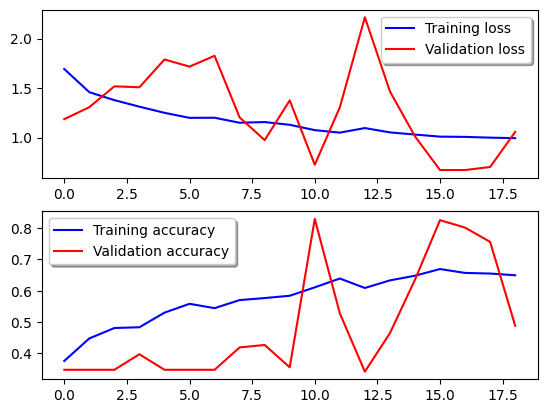

In [7]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
if 'val_loss' in history.history:
    ax[0].plot(history.history['val_loss'], color='r', label="Validation loss")
ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history.get('categorical_accuracy', []), color='b', label="Training accuracy")
if 'val_categorical_accuracy' in history.history:
    ax[1].plot(history.history['val_categorical_accuracy'], color='r', label="Validation accuracy")
ax[1].legend(loc='best', shadow=True)

In [9]:
# Save the model
import os
path_to = 'src/inference/models'
# Save the entire model (SavedModel format) and an HDF5 copy for portability
# model.save(os.path.join(path_to,'rps_cnn_saved'))   # TensorFlow SavedModel
model.save(os.path.join(path_to,'rps_cnn.h5'))      # HDF5

print("Model saved to 'rps_cnn_saved' and 'rps_cnn.h5'.")

Model saved to 'rps_cnn_saved' and 'rps_cnn.h5'.
